# <center>NLP: Topic Modeling for Riyadh Newspaper Articles</center>



**DATA**: We are planning to use our previously **scraped** data from the Riyadh Newspaper website **in Arabic**, ~3GB, plus some additional data (MetaData) that could add a meaningful sense to our project, see [Riyadh Newspaper website](http://www.alriyadh.com/1814297) to understand how we scraped the data.

**EXPECTED OUTPUT**: At the end of this project we expect to be done NLP **Topic Modeling** on Riyadh Newspaper articles, and all it's required preproccesing steps in addition to approperiate visualization.

**BONUS TASKS**: 
- Scraping ~3GB Data. 
- Using SQL Database for data storage. 
- As a challenge, we used data written in Arabic.

# 1. Data

In [1]:
import pandas  as pd
import numpy as np
#np.random.bit_generator = np.random._bit_generator
import matplotlib.pyplot as plt
import seaborn as sns
import pyodbc
import unicodedata
import re

import nltk # pip install nltk 
from nltk.tokenize import word_tokenize 
from nltk.tokenize import wordpunct_tokenize 
from nltk.tokenize import sent_tokenize
from nltk.corpus import stopwords
# nltk.download('stopwords')
from nltk.stem.isri import ISRIStemmer

from sklearn.feature_extraction.text import TfidfVectorizer

import re

import pandas as pd
from pprint import pprint
import pyodbc
# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
 
# spacy for lemmatization
#import spacy
 
# Plotting tools
#import pyLDAvis
#import pyLDAvis.gensim_models as gensimvis  # don't skip this
#pyLDAvis.enable_notebook()
import matplotlib.pyplot as plt
%matplotlib inline
 
# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
 
import warnings
#warnings.filterwarnings("ignore",category=DeprecationWarning)
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('arabic')




In [2]:
np.__version__
pd.__version__

'0.25.3'

### Reading From Database

In [3]:
server = 't5.database.windows.net'
server='DESKTOP-ASD2RK7\SQLEXPRESS'
database = 'T5' 
username = 'T5' 
password = 'My404Data' 
database = 'Riyadh2'
username ='sab'
password = 'tata2015'
cnxn = pyodbc.connect('DRIVER={SQL Server};SERVER='+server+';DATABASE='+database+';UID='+username+';PWD='+ password)
cursor = cnxn.cursor()
# where a_words>150 and a_words <501
df= pd.read_sql("select   * from texts inner join articles on t_aid = a_id ",cnxn)
#df.to_csv("texts3.csv",encoding='utf-8-sig')

In [4]:
# Merging was done on database level to reduce memory, 
# df = pd.read_sql("select * from articles",cnxn)
# df
# df.to_csv("metadata.csv", encoding='utf-8-sig')

In [5]:
# Merging was done on database level to reduce memory, 
# df2= pd.read_sql("select * from texts",cnxn)
# df2
# df2.to_csv("all_texts.csv",encoding='utf-8-sig')

### Reading CSVs Files

### Texts Dataset

In [6]:
## Merging was done on database level to reduce memory, 
#df_texts = pd.read_csv('all_texts.csv')

In [7]:
df.head(3)

,T_ID,T_AID,T_Text,A_ID,A_Link,A_LinkNum,A_Timestr,A_Cat,A_Auth,A_Title1,A_Title2,A_Paragraphs,A_Words,A_Characters
0,7,2,\nنشرت وكالة رويترز، اليوم الأحد الموافق 5 إبر...,2,http://www.alriyadh.com/1814297,1814297,&nbsp; \n\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\...,المحليات,"الرياض - ""الرياض""",إلى ما بعد اجتماع مجموعة أوبك بلس,السعودية تؤجل الإعلان عن أسعار الخام لشهر مايو,8,339,1962
1,8,4,\nبدأت إدارة التعليم في محافظة وادي الدواسر ، ...,4,http://www.alriyadh.com/1814296,1814296,&nbsp; \n\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\...,المحليات,وادي الدواسر - سعود آل مسيب,,تعليم وادي الدواسر يبدأ المرحلة الثانية من خطة...,3,183,1162
2,9,6,\nأودع صندوق تنمية الموارد البشرية (هدف)، اليو...,6,http://www.alriyadh.com/1814295,1814295,&nbsp; \n\t\t\t\t\t\t\n\t\t\t\t\t\t\t\t\t\t\t\...,المحليات,الرياض - محمد الحيدر,من برنامج إعانة الباحثين عن عمل,"""هدف"" يودع 446 مليون ريال في حسابات المستفيدين",4,190,1148


In [8]:
#df_texts.shape
df.shape

(283762, 14)

### Metadata  Dataset

In [9]:
# Merging was done on database level to reduce memory, 
#df_metadata = pd.read_csv('metadata.csv')

In [10]:
# Merging was done on database level to reduce memory, 
#df_metadata.head(3)

In [11]:
#df_metadata.shape

### Merge  Datasets

In [12]:
# Merging was done on database level to reduce memory, 
#df = pd.merge(df_texts, df_metadata, how='inner', left_on='T_AID', right_on='A_ID')
#print(df.shape)
df = df[['T_AID', 'A_Link', 'T_Text', 'A_Cat', 'A_Title1', 'A_Title2', 'A_Words']]
df.head(3)

,T_AID,A_Link,T_Text,A_Cat,A_Title1,A_Title2,A_Words
0,2,http://www.alriyadh.com/1814297,\nنشرت وكالة رويترز، اليوم الأحد الموافق 5 إبر...,المحليات,إلى ما بعد اجتماع مجموعة أوبك بلس,السعودية تؤجل الإعلان عن أسعار الخام لشهر مايو,339
1,4,http://www.alriyadh.com/1814296,\nبدأت إدارة التعليم في محافظة وادي الدواسر ، ...,المحليات,,تعليم وادي الدواسر يبدأ المرحلة الثانية من خطة...,183
2,6,http://www.alriyadh.com/1814295,\nأودع صندوق تنمية الموارد البشرية (هدف)، اليو...,المحليات,من برنامج إعانة الباحثين عن عمل,"""هدف"" يودع 446 مليون ريال في حسابات المستفيدين",190


# 2. EDA

### Missing Values & Duplicates

In [13]:
print(f'Number of missing values is {df.T_Text.isna().sum()}\nNumber of duplicated rows is {df.T_Text.duplicated().sum()}')

Number of missing values is 0
Number of duplicated rows is 8121


In [14]:
df.dropna(subset=['T_Text'], inplace=True)
df.drop_duplicates(subset=['T_Text'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,T_AID,A_Link,T_Text,A_Cat,A_Title1,A_Title2,A_Words
0,2,http://www.alriyadh.com/1814297,\nنشرت وكالة رويترز، اليوم الأحد الموافق 5 إبر...,المحليات,إلى ما بعد اجتماع مجموعة أوبك بلس,السعودية تؤجل الإعلان عن أسعار الخام لشهر مايو,339
1,4,http://www.alriyadh.com/1814296,\nبدأت إدارة التعليم في محافظة وادي الدواسر ، ...,المحليات,,تعليم وادي الدواسر يبدأ المرحلة الثانية من خطة...,183
2,6,http://www.alriyadh.com/1814295,\nأودع صندوق تنمية الموارد البشرية (هدف)، اليو...,المحليات,من برنامج إعانة الباحثين عن عمل,"""هدف"" يودع 446 مليون ريال في حسابات المستفيدين",190
3,8,http://www.alriyadh.com/1814294,\nإشارة لما أعلنته وزارة النفط والمعادن اليمني...,الدولية,,التحالف : إطلاق المليشيا الحوثية صاروخ بالستي...,198
4,10,http://www.alriyadh.com/1814293,\nاستمرارًا للجهود التي تقوم بها (الصحة) للتصد...,المحليات,,التجمع الصحي الأول : توصيل الأدوية إلى المناز...,139
...,...,...,...,...,...,...,...
275636,567519,http://www.alriyadh.com/1500027,\nاعتمد مدير عام التعليم في منطقة عسير بالنياب...,المحليات,,39 مليون ريال مكافآت طلاب وطالبات تعليم عسير,110
275637,567521,http://www.alriyadh.com/1500026,\nينظم المكتب التعاوني للدعوة والإرشاد وتوعية ...,المحليات,,كلمات وعظية في مساجد حي سلطانة بالرياض,263
275638,567523,http://www.alriyadh.com/1500025,\nناقشت اللجنة المنظمة لمهرجان الحبحب لعام 143...,المحليات,,التحضير لانطلاق مهرجان الحبحب بوادي الدواسر,127
275639,567525,http://www.alriyadh.com/1500024,\nرعى محافظ حفر الباطن عبدالمحسن بن محمد العطي...,المحليات,,محافظ حفر الباطن يفتتح مجمع مدارس شعلة الإيمان...,189


### Articles Lengths (Words)

In [15]:
df[df['A_Words'] == 4].iloc[2]['T_Text']

'\nأجل من حظ الوحدة!'

In [16]:
df[df['A_Words'] == df['A_Words'].max()]['T_Text'][235403]

'\nدعت وزارة الخدمة المدنية (5000) متقدمة على الوظائف المشمولة بلائحة الوظائف التعليمية المعلنة بتاريخ 20-12-1437هـ ، ويمثلن من تم ترشيحهن مبدئياً للمطابقة النهائية لبياناتهن لدى أي من فروع أو مكاتب الوزارة في مختلف مناطق ومحافظات المملكة وذلك اعتباراً من يوم غدٍ الأثنين الموافق 7-2-1438هـ وحتى نهاية دوام يوم الخميس القادم الموافق 10-2-1438هـ  خلال فترة الدوام الرسمي  مصطحبات معهن ما يلي :-\nالهوية الوطنية مع صورة منها ، أو سجل الأسرة المضافة به المتقدمة.\nوثيقة التخرج الأصلية مع صوره منها ، موضحاً فيها التقدير العام والنسبة المئوية أو المعدل التراكمي وتاريخ التخرج بالإضافة الى كشف الدرجات .\nالحاصلات على المؤهلات الخارجية يتطلب منهن إرفاق معادلة لجنة المعادلات بوزارة التعليم مع ارفاق مفاتيح المعدل مع نسخة منها.\nالحاصلات على الدبلوم التربوي يتطلب إرفاق وثيقة الدبلوم العام في التربية مع نسخة منه ، في حال كون المتقدمة تحمل مؤهلاً غير تربوياً.\nالحاصلات على دبلوم التربية الخاصة يتطلب إرفاق وثيقة دبلوم التربية الخاصة مع نسخة منها.\nوتؤكد وزارة الخدمة المدنية إلى أن من لم تحضر أصول الوثائق

In [17]:
def plot_articles_lenghts():
    plt.figure(figsize=(16, 5))
    plt.grid()
    plt.hist(df['A_Words'], bins=70);
    plt.show();

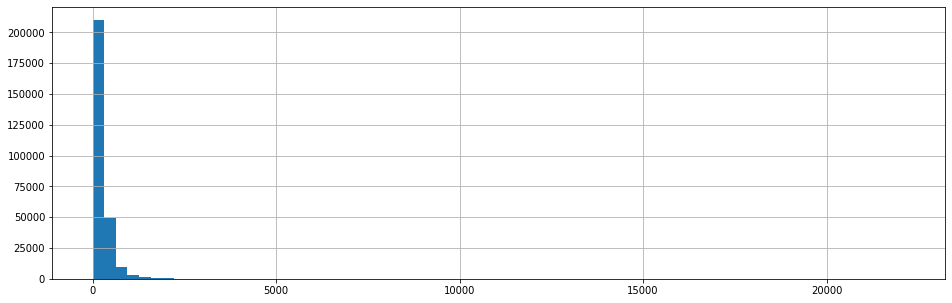

In [18]:
plot_articles_lenghts()

In [19]:
# Wrong Texts (i.e. very long/short texts)
df = df[((df['A_Words'] >= 150) & (df['A_Words'] <= 500))].copy()
df.reset_index(drop=True, inplace=True)

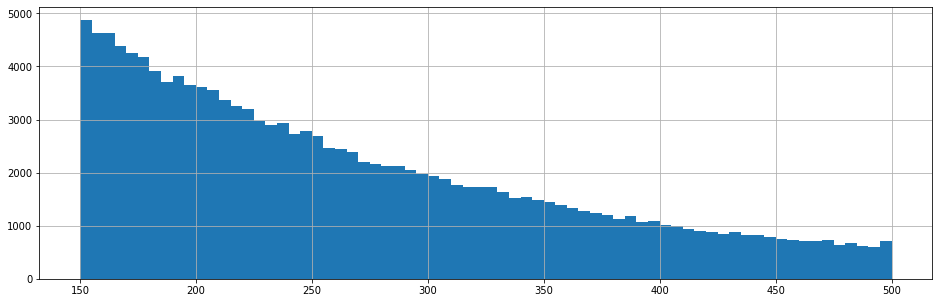

In [20]:
plot_articles_lenghts()

### Cleaning Text

In [21]:
df['T_Text'][8]

'\nتسبب تفشي فيروس كورونا المستجد في تأجيل عملية قلب كان من المفترض أن يخضع لها أنطوني روبنسون ظهير أيسر فريق ويجان الإنجليزي.\nوكان من المقرر أن يخضع اللاعب الأمريكي الدولي روبنسون لعملية جراحية لتصحيح انتظام ضربات القلب، عقب اكتشافه لذلك في يناير الماضي، حينما كان يستعد للانضمام لصفوف ميلان الإيطالي في فترة الانتقالات الشتوية.\nوتأجلت عملية روبنسون البالغ من العمر 22 عاما مرتين ويبدو انه سينتظر لفترة أطول من أجل إجرائها.\nويأمل اللاعب المولود في إنجلترا في إمكانية إجراء العملية في وقت يترواح ما بين ستة إلى ثماني أسابيع، ليتمكن من العودة إلى الملاعب في حال استئناف الموسم.\nولا يبدو أن الوقت الحالي يحمل أي بوادر لتطورات جديدة في مسيرة روبنسون، الذي لم يشارك في أي مباراة منذ أواخر يناير الماضي، حيث تتطلب مشاركته في المباريات حال استئناف المسابقات مجددا ان يجري العملية ويكون في كامل لياقته.\nوذكرت صحيفة "ذي صن" البريطانية ان ميلان لازال يامل في ضم اللاعب، لكنه ينتظر ان ينهي العملية التي تأجلت مرتين.'

In [22]:
# remove (\n, \xa0..)
df['T_Text'] = df['T_Text'].apply(lambda x: unicodedata.normalize("NFKC", x.replace('\n', ' '))).astype(str)

# remove (non-arabic-alphabet)
df['T_Text'] = df['T_Text'].str.replace('[^ء-ي ]', '')

# replcae (أ,آ,إ) by (ا)
df['T_Text'] = df['T_Text'].apply(lambda x: re.sub('[أإآ]', 'ا', x))

# replace (ة) by (ه)
df['T_Text'] = df['T_Text'].apply(lambda x: re.sub('[ة]', 'ه', x))

# remove multi spaces
df['T_Text'] = df['T_Text'].apply(lambda x: re.sub(' +', ' ', x).strip())


In [23]:
df['T_Text'][8]

'تسبب تفشي فيروس كورونا المستجد في تاجيل عمليه قلب كان من المفترض ان يخضع لها انطوني روبنسون ظهير ايسر فريق ويجان الانجليزي وكان من المقرر ان يخضع اللاعب الامريكي الدولي روبنسون لعمليه جراحيه لتصحيح انتظام ضربات القلب عقب اكتشافه لذلك في يناير الماضي حينما كان يستعد للانضمام لصفوف ميلان الايطالي في فتره الانتقالات الشتويه وتاجلت عمليه روبنسون البالغ من العمر عاما مرتين ويبدو انه سينتظر لفتره اطول من اجل اجرائها ويامل اللاعب المولود في انجلترا في امكانيه اجراء العمليه في وقت يترواح ما بين سته الى ثماني اسابيع ليتمكن من العوده الى الملاعب في حال استئناف الموسم ولا يبدو ان الوقت الحالي يحمل اي بوادر لتطورات جديده في مسيره روبنسون الذي لم يشارك في اي مباراه منذ اواخر يناير الماضي حيث تتطلب مشاركته في المباريات حال استئناف المسابقات مجددا ان يجري العمليه ويكون في كامل لياقته وذكرت صحيفه ذي صن البريطانيه ان ميلان لازال يامل في ضم اللاعب لكنه ينتظر ان ينهي العمليه التي تاجلت مرتين'

# 3. Preprocessing

### 3.1. Tokenization

In [24]:
# done differently using gensim
#df['T_Text'] = df['T_Text'].apply(lambda x: wordpunct_tokenize(x)).to_numpy()
#df['T_Text'][0]
data = list(df['T_Text'].tolist())
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
 
data_words = list(sent_to_words(data))
 
print(data_words[:1])

[['نشرت', 'وكاله', 'رويترز', 'اليوم', 'الاحد', 'الموافق', 'ابريل', 'تقريرا', 'استنادا', 'الى', 'مصدر', 'سعودي', 'رفيع', 'مطلع', 'على', 'الاوضاع', 'البتروليه', 'جاء', 'فيه', 'ان', 'شركه', 'الزيت', 'العربيه', 'السعوديه', 'ارامكو', 'السعوديه', 'ستوجل', 'الاعلان', 'عن', 'اسعار', 'البيع', 'الرسميه', 'للبترول', 'الخام', 'لشهر', 'مايو', 'القادم', 'حتى', 'العاشر', 'من', 'ابريل', 'الجاري', 'انتظارا', 'لنتايج', 'اجتماع', 'مرتقب', 'بين', 'الدول', 'الاعضاء', 'في', 'منظمه', 'اوبك', 'وحلفايهم', 'لمناقشه', 'تخفيضات', 'محتمله', 'في', 'الانتاج', 'واضافت', 'رويترز', 'ان', 'المصدر', 'نفسه', 'قال', 'ان', 'ارامكو', 'السعوديه', 'لم', 'يسبق', 'لها', 'ان', 'اتخذت', 'مثل', 'هذا', 'الاجراء', 'حيث', 'ستعتمد', 'الاسعار', 'الرسميه', 'لبيع', 'الخام', 'في', 'شهر', 'مايو', 'على', 'ما', 'ينتهي', 'اليه', 'اجتماع', 'مجموعه', 'اوبك', 'بلس', 'المنتظر', 'واشار', 'المصدر', 'الى', 'ان', 'المملكه', 'تبذل', 'كل', 'ما', 'في', 'وسعها', 'لانجاح', 'هذا', 'الاجتماع', 'ومن', 'ذلك', 'اتخاذ', 'هذه', 'الخطوه', 'غير', 'العاديه', 'المتمث

### 3.3. Stop words removal & Bigrams

In [25]:
stop_words = stopwords.words('arabic')
stop_words.extend(['هـ', 'د', 'م', 'الى', 'ان', 'اذ', 'لهذه', 'قال', 'وقال', 'اكد', 'عدد', 'بعدد', 'وعدد'
                  , 'والتي', 'بن', 'بنت', 'وقد', 'ا', 'عبر', 'خلال', 'او', 'الا', 'وان', 'اي', 'بان', 'كان'
                  , 'كانت' ,'تم','الف','مليون', 'وفي', 'وقد','اكثر','اقل', 'انه','وانه', 'قالت', 'وقالت', 'وتم'])

#df['T_Text_Clean'] = df['T_Text'].apply(lambda x: [word for word in x if word not in stop_words])
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]
 
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  
 
# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)
 

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]
 
def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]


data_words_nostops = remove_stopwords(data_words)
 
# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

In [26]:
#df['T_Text_Clean'][0]
data_words_bigrams[0]

['نشرت',
 'وكاله_رويترز',
 'اليوم',
 'الاحد',
 'الموافق_ابريل',
 'تقريرا',
 'استنادا',
 'مصدر',
 'سعودي',
 'رفيع',
 'مطلع',
 'الاوضاع',
 'البتروليه',
 'جاء',
 'شركه',
 'الزيت',
 'العربيه',
 'السعوديه',
 'ارامكو',
 'السعوديه',
 'ستوجل',
 'الاعلان',
 'اسعار',
 'البيع',
 'الرسميه',
 'للبترول',
 'الخام',
 'لشهر',
 'القادم',
 'العاشر',
 'ابريل',
 'الجاري',
 'انتظارا',
 'لنتايج',
 'اجتماع',
 'مرتقب',
 'الدول_الاعضاء',
 'منظمه_اوبك',
 'وحلفايهم',
 'لمناقشه',
 'تخفيضات',
 'محتمله',
 'الانتاج',
 'واضافت',
 'رويترز',
 'المصدر',
 'نفسه',
 'ارامكو',
 'السعوديه',
 'يسبق',
 'اتخذت',
 'الاجراء',
 'ستعتمد',
 'الاسعار',
 'الرسميه',
 'لبيع',
 'الخام',
 'شهر',
 'ينتهي',
 'اليه',
 'اجتماع',
 'مجموعه',
 'اوبك_بلس',
 'المنتظر',
 'واشار',
 'المصدر',
 'المملكه',
 'تبذل',
 'وسعها',
 'لانجاح',
 'الاجتماع',
 'اتخاذ',
 'الخطوه',
 'العاديه',
 'المتمثله',
 'تاخير',
 'اصدار',
 'اسعار',
 'بيع',
 'الخام',
 'الرسميه',
 'والمعروف',
 'ارامكو',
 'السعوديه',
 'عاده',
 'تصدر',
 'اسعار',
 'بيع',
 'الخام',
 'الرسميه',
 'بحلول

### 3.4. Stemming or Lemmatization

In [27]:
#st = ISRIStemmer()

#df['T_Text_St'] = df['T_Text_Clean'].apply(lambda x: [st.stem(word) for word in x])
#df['T_Text_St'][0]

In [28]:
#df.to_csv('prepared.csv')

In [29]:
#pd.read_csv('prepared.csv', usecols=['T_Text_St'])

# 4. Encoding (???, TFIDF or Bag of Word)

### 4.1. ???

### 4.2. TFIDF

In [30]:
#Not needed using gensim
#vectorizer = TfidfVectorizer()
#vectors = vectorizer.fit_transform([text, text])
#feature_names = vectorizer.get_feature_names()
#dense = vectors.todense()
#denselist = dense.tolist()
#df = pd.DataFrame(denselist, columns=feature_names)
#df

### 4.3. Creating id2word


In [31]:
# Create Dictionary
id2word = corpora.Dictionary(data_words_bigrams)
 
# Create Corpus
texts = data_words_bigrams
 
# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]
 
# View
print(corpus[:1])

[[(0, 3), (1, 1), (2, 1), (3, 1), (4, 2), (5, 4), (6, 1), (7, 3), (8, 1), (9, 5), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 2), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 1), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 1), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 2), (37, 6), (38, 1), (39, 1), (40, 1), (41, 2), (42, 2), (43, 4), (44, 1), (45, 1), (46, 2), (47, 5), (48, 1), (49, 1), (50, 1), (51, 2), (52, 2), (53, 2), (54, 1), (55, 1), (56, 1), (57, 4), (58, 1), (59, 3), (60, 2), (61, 1), (62, 1), (63, 1), (64, 1), (65, 1), (66, 1), (67, 1), (68, 1), (69, 1), (70, 1), (71, 1), (72, 5), (73, 1), (74, 1), (75, 1), (76, 1), (77, 1), (78, 1), (79, 1), (80, 1), (81, 2), (82, 1), (83, 1), (84, 1), (85, 1), (86, 1), (87, 1), (88, 1), (89, 1), (90, 1), (91, 1), (92, 1), (93, 1), (94, 1), (95, 1), (96, 1), (97, 1), (98, 1), (99, 1), (100, 1), (101, 1), (102, 1), (103, 1), (104, 1), (105, 1), (106, 1), (107, 1), (108, 2), (109, 4), (110, 1)

# 5. Topic Modeling

### 5.1. LDA

In [32]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=40, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=2,
                                           alpha='auto',
                                           per_word_topics=True)

In [46]:
# Print the Keyword in topics
#pprint(lda_model.print_topics(40,10))
x = lda_model.print_topics(40,10)
terms = []
for u in range(0,40):
    y = lda_model.show_topic(u,10)
    yz = [yo[0] for yo in y]
    terms.append(yz)
df_topics = pd.DataFrame(terms)
df_topics = df_topics.transpose()
doc_lda = lda_model[corpus]

In [47]:
df_topics.iloc[:,30:40]

,30,31,32,33,34,35,36,37,38,39
0,المعرض,الكتاب,الانديه,العام,عبداللطيف_جميل,الهييه,الله,المركز,المملكه,ايران
1,الرياض,الحياه,الاتحاد,السوق,الصندوق,المنشات,الشيخ,مركز,الاعمال,ضد
2,المهرجان,الناس,السعودي,الشركه,العثيم,القبول,عبدالعزيز,الملك,مجلس,الارهاب
3,الفعاليات,وهي,السعوديه,عام,عبدالله_العثيم,يوم,العام,الحمله,الهييه,النظام
4,فعاليات,انها,وهذا,شركه,اسواق,المضافه,الملك,السعوديه,رييس,الايرانيه
5,معرض,احد,الرياضيه,الماليه,الزراعيه,الضريبه,الشريفين,الانسانيه,السعوديه,الارهابيه
6,مجموعه,الشاعر,يكون,بنسبه,شركه,للهييه,الحج,سلمان_للاغاثه,الاقتصاديه,الدوله
7,السعوديه,الشعر,رييس,مليار,الشركه,التسجيل,خادم_الحرمين,الربيعه,قطاع,المجتمع
8,المملكه,اما,الرياضه,المملكه,برنامج,المحرر,المملكه,المساعدات,المجلس,الامن
9,العديد,يقول,الرياضي,نسبه,الزراعه,شوال,مكه_المكرمه,الانساني,رويه,الدول


## 5.2  metrics

In [69]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.
 
# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_words_bigrams, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCohe rence Score: ', coherence_lda)


Perplexity:  -13.009025182563132

Cohe rence Score:  0.5786561852921805


### 5.2. ???

In [45]:
doc_lda = [doc for doc in lda_corpus]

NameError: name 'lda_corpus' is not defined

# 6. Finding Oprimal number of topics

In [ ]:

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics
    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics
    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=10000,
                                           passes=2,
                                           alpha='auto',
                                           per_word_topics=False)
        #model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
 
    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_words_bigrams, start=2, limit=50, step=6)

In [ ]:
# Show graph
limit=50; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

# Merging Genres, Article title with LDA Results

In [ ]:
# Store the documents' topic vectors in a list so we can take a peak
lda_docs = [doc for doc in lda_model[corpus]]

In [ ]:
#get a dataframe with topic A_ID to merge it
df6 = pd.DataFrame(columns=['ArticleID','TopicID','Perc'],dtype='object')
def func(x):
    #pass
    #print(x['index'])
    global df6
    for x1 in x['D']:
        #print(x1[1])
        #df6.iloc[-1] = [0,x1[0],x1[1]]
        df6 = df6.append(pd.DataFrame(columns=['ArticleID','TopicID','Perc'],data=[[x['index'],x1[0],x1[1]]]))
        #df6.index = df6.index+1


df5 = pd.DataFrame(columns = ["D"],data=zip(lda_docs))
#a = np.array(lda_docs[2])
#a[:,1].max()

#df5['Perc'] = df5['D'].apply(lambda x:list(zip(x))[0][0][1])
df5 = df5.reset_index()
df5.apply(lambda x:func(x),axis=1)
df5.head()
df6.head()

In [ ]:
# merge article, topic id, and article title, genre in original frame
df7 = pd.merge(df6,df,how='left',left_on='ArticleID',right_on='index')
df7[df7['TopicID']==9][['ArticleID','TopicID','Perc','A_Cat','A_Title1','A_Title2','T_Text']]


#df7.head()
#df7.to_csv("articles_Topics1.csv",encoding='utf-8-sig')
df7.shape